Grid Search Results:

Optimal First Bid (estimated): 200
Optimal Second Bid (estimated): 255
Maximum Average Profit (estimated): 115.57


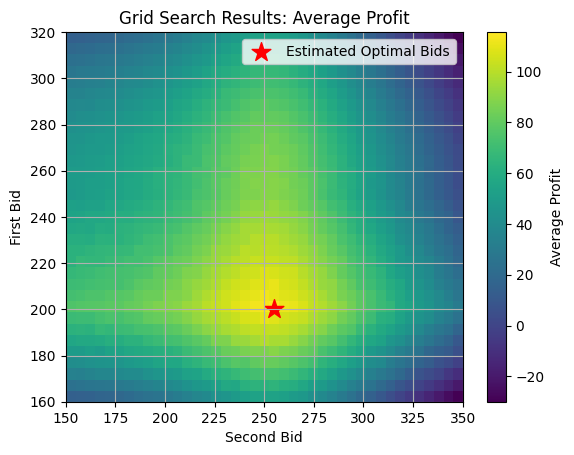

In [6]:
import numpy as np
import random
import matplotlib.pyplot as plt

def get_reserve_price():
    """Simulates the reserve price of a sea turtle."""
    if random.random() < 0.5:  # Equal probability for each range
        return random.uniform(160, 200)
    else:
        return random.uniform(250, 320)

def calculate_pnl_second_bid(your_bid, avg_other_bids):
    """Calculates the PNL for the second bid."""
    if your_bid > avg_other_bids:
        return 320 - your_bid
    elif your_bid < avg_other_bids:
        if 320 - your_bid == 0:  # Avoid division by zero
            return 0
        p = ((320 - avg_other_bids) / (320 - your_bid)) ** 3
        return (320 - your_bid) * p
    else:
        return 0  # Assuming no profit if exactly equal

def simulate_round(first_bid, second_bid, num_other_traders):
    """Simulates one round of bidding."""
    profit = 0

    # First bid
    reserve_price = get_reserve_price()
    if first_bid > reserve_price and (reserve_price < 200 or reserve_price >= 250):
        profit += 320 - first_bid

    # Second bid (assuming other traders bid randomly for simulation)
    other_second_bids = [random.uniform(150, 350) for _ in range(num_other_traders)] # Adjust range as needed
    avg_other_bids = np.mean(other_second_bids) if other_second_bids else 0
    profit += calculate_pnl_second_bid(second_bid, avg_other_bids)

    return profit

def grid_search(first_bid_range, second_bid_range, num_simulations, num_other_traders):
    """Performs a grid search to find potentially optimal bids."""
    results = {}
    for b1 in first_bid_range:
        results[b1] = {}
        for b2 in second_bid_range:
            total_profit = 0
            for _ in range(num_simulations):
                total_profit += simulate_round(b1, b2, num_other_traders)
            avg_profit = total_profit / num_simulations
            results[b1][b2] = avg_profit

    # Find the bids with the highest average profit
    best_b1 = None
    best_b2 = None
    max_avg_profit = -float('inf')

    for b1, b2_profits in results.items():
        for b2, avg_profit in b2_profits.items():
            if avg_profit > max_avg_profit:
                max_avg_profit = avg_profit
                best_b1 = b1
                best_b2 = b2

    return results, best_b1, best_b2, max_avg_profit

if __name__ == "__main__":
    # Define the ranges for the grid search
    first_bid_range = range(160, 321, 5)  # Check bids in increments of 5
    second_bid_range = range(150, 351, 5) # Wider range for the second bid

    # Set the number of simulations and the number of other traders
    num_simulations = 5000
    num_other_traders = 10  # You can adjust this

    # Perform the grid search
    grid_search_results, optimal_b1, optimal_b2, max_profit = grid_search(
        first_bid_range, second_bid_range, num_simulations, num_other_traders
    )

    print("Grid Search Results:")
    # You can print the entire results dictionary if needed, but it might be large
    # for b1, b2_profits in grid_search_results.items():
    #     print(f"First Bid: {b1}, Second Bid Profits: {b2_profits}")

    print(f"\nOptimal First Bid (estimated): {optimal_b1}")
    print(f"Optimal Second Bid (estimated): {optimal_b2}")
    print(f"Maximum Average Profit (estimated): {max_profit:.2f}")

    # Visualize the results (optional, but helpful)
    b1_values = sorted(list(grid_search_results.keys()))
    b2_values = sorted(list(next(iter(grid_search_results.values())).keys()))
    profit_matrix = np.array([[grid_search_results[b1][b2] for b2 in b2_values] for b1 in b1_values])

    plt.imshow(profit_matrix, origin='lower', extent=[min(b2_values), max(b2_values), min(b1_values), max(b1_values)], aspect='auto', cmap='viridis')
    plt.colorbar(label='Average Profit')
    plt.xlabel('Second Bid')
    plt.ylabel('First Bid')
    plt.title('Grid Search Results: Average Profit')
    plt.scatter(optimal_b2, optimal_b1, color='red', marker='*', s=200, label='Estimated Optimal Bids')
    plt.legend()
    plt.grid(True)
    plt.show()

Optimal first bid: 200.00
Expected profit from first bid: 60.00

Optimal second bids for different average bid scenarios:
Average bid: 250.00 → Optimal bid: 250.00, Expected profit: 70.00
Average bid: 270.00 → Optimal bid: 270.00, Expected profit: 50.00
Average bid: 290.00 → Optimal bid: 290.00, Expected profit: 30.00
Average bid: 310.00 → Optimal bid: 310.00, Expected profit: 10.00

Analyzing robust second bid strategy (assuming uniform distribution of average bids)
Robust optimal second bid: 272.91
Expected profit with robust strategy: 23.34

=== FINAL BIDDING STRATEGY RECOMMENDATION ===
First bid: 200.00
Second bid: 272.91
Expected total profit: 83.34


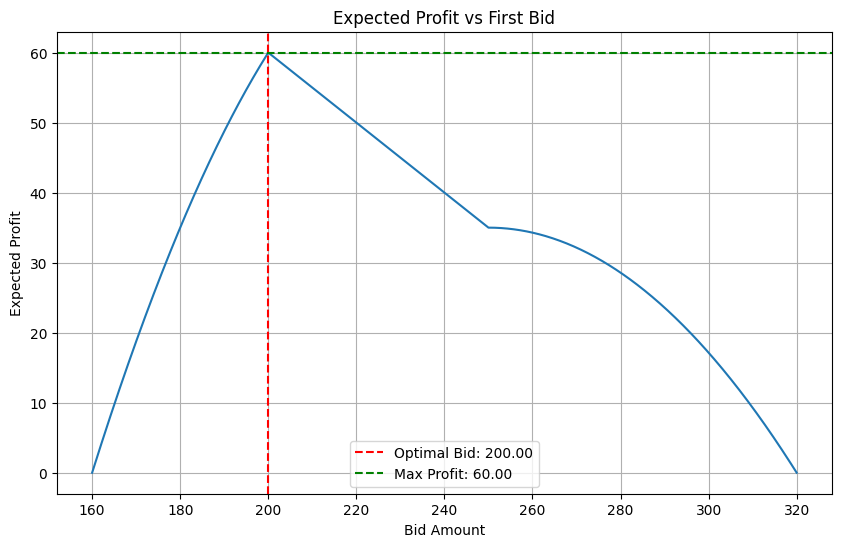

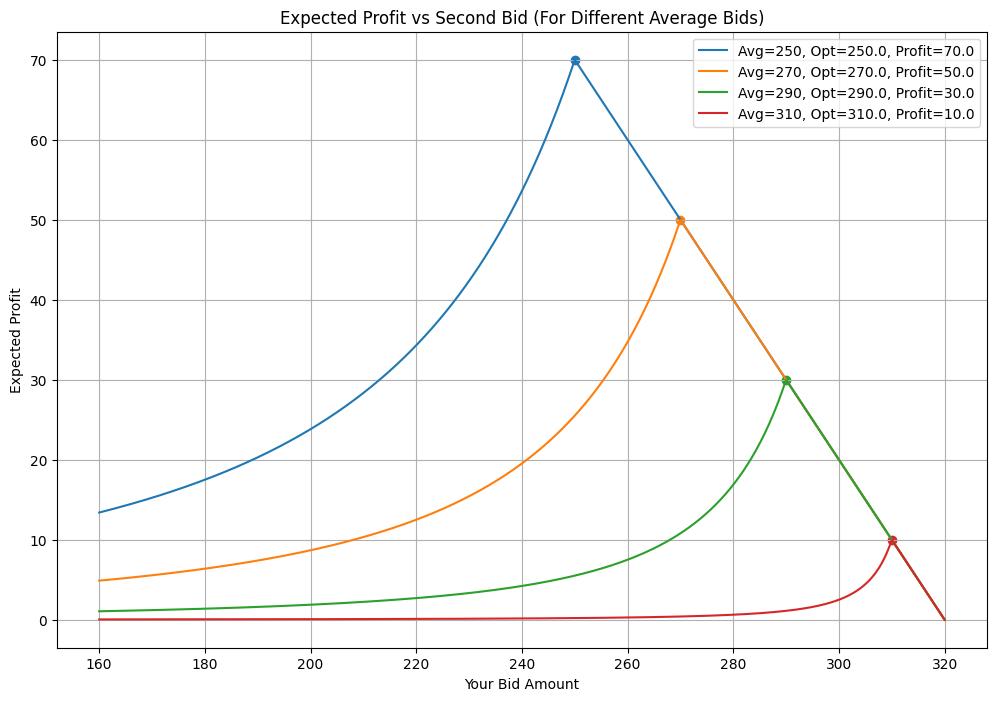

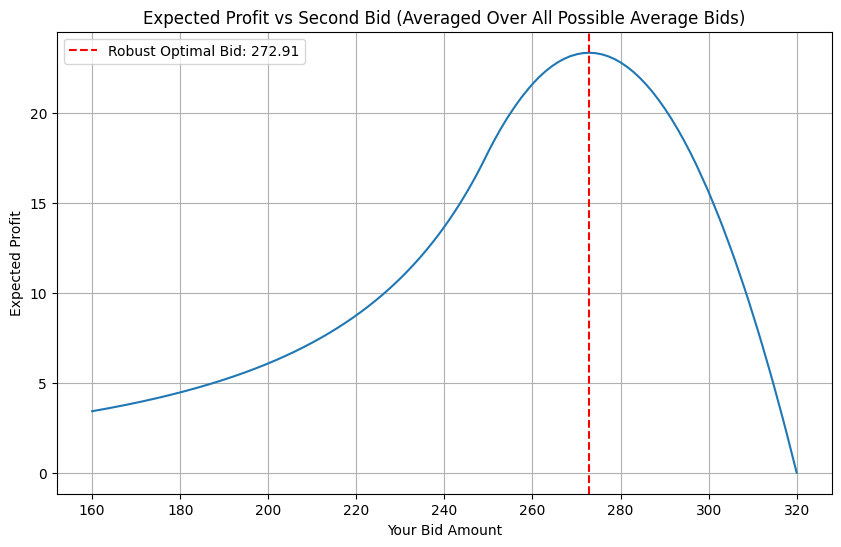

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar

# Constants
RESELL_PRICE = 320

def expected_profit_first_bid(bid):
    """Calculate expected profit for first bid."""
    profit_per_deal = RESELL_PRICE - bid
    
    # Probability of successful deal
    if bid < 160:
        prob_success = 0  # No turtle will accept below 160
    elif 160 <= bid <= 200:
        prob_success = (bid - 160) / (200 - 160) * 0.5  # Linear probability in first range
    elif 200 < bid < 250:
        prob_success = 0.5  # All turtles in first range accept
    elif 250 <= bid <= 320:
        prob_success = 0.5 + (bid - 250) / (320 - 250) * 0.5  # Add probability from second range
    else:  # bid > 320
        prob_success = 1.0  # All turtles accept
    
    return profit_per_deal * prob_success

def success_probability_second_bid(your_bid, avg_bid):
    """Calculate probability of success for second bid."""
    if your_bid >= avg_bid:
        return 1.0
    else:
        p = ((320 - avg_bid) / (320 - your_bid))**3
        return p

def expected_profit_second_bid(bid, avg_bid):
    """Calculate expected profit for second bid given an average bid."""
    profit_per_deal = RESELL_PRICE - bid
    prob_success = success_probability_second_bid(bid, avg_bid)
    return profit_per_deal * prob_success

def negative_profit_first_bid(bid):
    """For optimization (scipy minimizes, so we negate profit)"""
    return -expected_profit_first_bid(bid)

def negative_profit_second_bid(bid, avg_bid):
    """For optimization (scipy minimizes, so we negate profit)"""
    return -expected_profit_second_bid(bid, avg_bid)

# Analyze first bid
result_first = minimize_scalar(negative_profit_first_bid, bounds=(160, 320), method='bounded')
optimal_first_bid = result_first.x
max_profit_first = -result_first.fun

print(f"Optimal first bid: {optimal_first_bid:.2f}")
print(f"Expected profit from first bid: {max_profit_first:.2f}")

# Plot first bid analysis
bids = np.linspace(160, 320, 1000)
profits = [expected_profit_first_bid(bid) for bid in bids]

plt.figure(figsize=(10, 6))
plt.plot(bids, profits)
plt.axvline(x=optimal_first_bid, color='r', linestyle='--', label=f'Optimal Bid: {optimal_first_bid:.2f}')
plt.axhline(y=max_profit_first, color='g', linestyle='--', label=f'Max Profit: {max_profit_first:.2f}')
plt.title('Expected Profit vs First Bid')
plt.xlabel('Bid Amount')
plt.ylabel('Expected Profit')
plt.legend()
plt.grid(True)
plt.savefig('first_bid_analysis.png')

# Analyze second bid for different average bid scenarios
avg_bids = [250, 270, 290, 310]
bid_range = np.linspace(160, 320, 1000)

plt.figure(figsize=(12, 8))
optimal_seconds = []

for avg in avg_bids:
    # Find optimal bid for this average
    result = minimize_scalar(lambda bid: negative_profit_second_bid(bid, avg), 
                            bounds=(160, 320), method='bounded')
    optimal_bid = result.x
    max_profit = -result.fun
    optimal_seconds.append((avg, optimal_bid, max_profit))
    
    # Plot profit curve
    profits = [expected_profit_second_bid(bid, avg) for bid in bid_range]
    plt.plot(bid_range, profits, label=f'Avg={avg}, Opt={optimal_bid:.1f}, Profit={max_profit:.1f}')
    
    # Mark optimal point
    plt.scatter(optimal_bid, max_profit, marker='o')

plt.title('Expected Profit vs Second Bid (For Different Average Bids)')
plt.xlabel('Your Bid Amount')
plt.ylabel('Expected Profit')
plt.legend()
plt.grid(True)
plt.savefig('second_bid_analysis.png')

# Print optimal second bids
print("\nOptimal second bids for different average bid scenarios:")
for avg, opt, profit in optimal_seconds:
    print(f"Average bid: {avg:.2f} → Optimal bid: {opt:.2f}, Expected profit: {profit:.2f}")

# Calculate a "robust" second bid strategy
print("\nAnalyzing robust second bid strategy (assuming uniform distribution of average bids)")
avg_range = np.linspace(250, 320, 50)  # Possible average bids
    
def expected_profit_over_avg_range(bid):
    """Calculate expected profit averaging over all possible average bids"""
    profits = [expected_profit_second_bid(bid, avg) for avg in avg_range]
    return np.mean(profits)

bids = np.linspace(160, 320, 1000)
avg_profits = [expected_profit_over_avg_range(bid) for bid in bids]
robust_bid = bids[np.argmax(avg_profits)]
robust_profit = max(avg_profits)

plt.figure(figsize=(10, 6))
plt.plot(bids, avg_profits)
plt.axvline(x=robust_bid, color='r', linestyle='--', 
           label=f'Robust Optimal Bid: {robust_bid:.2f}')
plt.title('Expected Profit vs Second Bid (Averaged Over All Possible Average Bids)')
plt.xlabel('Your Bid Amount')
plt.ylabel('Expected Profit')
plt.legend()
plt.grid(True)
plt.savefig('robust_second_bid.png')

print(f"Robust optimal second bid: {robust_bid:.2f}")
print(f"Expected profit with robust strategy: {robust_profit:.2f}")

# Final recommendation
print("\n=== FINAL BIDDING STRATEGY RECOMMENDATION ===")
print(f"First bid: {optimal_first_bid:.2f}")
print(f"Second bid: {robust_bid:.2f}")
print(f"Expected total profit: {max_profit_first + robust_profit:.2f}")